In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import Dropout
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from sklearn.decomposition import PCA
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
import seaborn as sb
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim, p_dropout):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = Tanh() # or ReLu
            
        self.dropout = Dropout(p_dropout)
        
        # output
        self.out = Linear(n_hidden,input_dim) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        #self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            hidden_layer[i] = self.dropout(hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        #output = self.actout(output)

        return output,hidden_layer

In [8]:
# train the model
def train_model(train_x,train_y, val_x,val_y,model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=0.005)
    
    # enumerate epochs
    all_loss = []
    lossdiff = -1
    epoch = 0
    model.train()
    while lossdiff<0:
        # enumerate batches (xx and xY batch)    
        for xi,yi,xv,yv in zip(train_x,train_y,val_x,val_y):
            
            # initialise hidden states
            batch_size = xi.size()[0]
            batch_size_val = xv.size()[0]
            hi = {}
            hiv = {}
            for k in range(n_layers):
                hi[k] = torch.zeros((batch_size,n_hidden))
                hiv[k] = torch.zeros((batch_size_val,n_hidden))
            lv = []
            for j in range(xi.size()[1]):# items in sequence
                xij = xi[:,j,:]
                yij = yi[:,j,:]
                # compute the model output
                yhat,hi = model(xij,hi)
                
                # validation
                xvj = xv[:,j,:]
                yvj = yv[:,j,:]
                yval,hiv = model(xvj,hiv)

                    
                if j>xi.size()[1]-5*5:
                    loss = criterion(yhat, yij)
                    lv.append(criterion(yval,yvj))
                    
                    
                    # clear the gradients
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    # update model weights
                    optimizer.step()
            
            loss_val = sum(lv)
        
        all_loss.append(loss_val.item())  
        if epoch>5:
            lossdiff = all_loss[-1]-np.mean(all_loss[-5:-1] )
        if epoch>500:
            lossdiff = 1
        epoch +=1
    return all_loss


def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    
    y = []
    h = []
    c = []
    model.eval()
    for xi in x:
        batch_size = xi.size()[0]
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
        
        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        yhat = yhat.detach().numpy() # predicted stimulus
        #ci = np.round(yhat) != xij.detach().numpy()
        ##print(np.sum(ci,1))
        #ci =  ((np.sum(ci,1)==0)==False).astype(int) # predicted sameness 1=change, 0=same
        y.append(yhat)
        #c.append(ci)
        h.append(hi)
        
    return y,h #,c


Create input sequences

In [9]:
def unique_pairs(dictionary):
    '''
    create matrix with unique pairs of (one-hot) vectors in dictionary
    
    dictionary: N x dimensionality; matrix of N (one-hot) vectors
    '''
    vecpairs = []
    for i in range(dictionary.shape[0]):
        for j in range(dictionary.shape[0]):
            if i!=j:
                vecpairs.append(np.vstack((dictionary[j,],dictionary[i,])))
    vecpairs = np.array(vecpairs) 
    return vecpairs

def make_sequence(seq,repeats,pairs,zero_vector,deviance_prob):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    zero_vector: vector to be used for the zero state
    deviance_prob: probability of global deviant
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        c = []
        for i in range(batch_size):
            a.append(pairs[i,0,:]) # X
            b.append(pairs[i,1,:]) # Y
            if pairs.shape[1]==3:
                c.append(pairs[i,2,:]) # Z
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)
            elif element==2:
                sequence.append(c)
        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        sequence = np.concatenate((sequence,np.repeat(zero_vector[None,:,:],batch_size,0)),1)
        out_sequence = sequence
        global_deviants = np.round(np.random.rand(repeats-2)-(0.5-deviance_prob))
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
            # insert global deviant according to global_Deviants for all chunks but last
            if r<repeats-2:
                if global_deviants[r]==1:
                    # check wich item is the last
                    if np.mean(out_sequence[:,-2]==a):
                        out_sequence[:,-2]=b #switch
                    else:
                        out_sequence[:,-2]=a
                
        all_seq.append(out_sequence)

    return all_seq


### Training & Testing on structure switch

Generate circular input data

In [10]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[1,1,1,1],[1,1,1,0]] # sequence structures to be used
seq_test = [[0,0,0,0],[0,0,0,1],[1,1,1,1],[1,1,1,0]]
seq_test2 = [[0,0,0,1],[0,0,0,0],[1,1,1,0],[1,1,1,1]] # those are the global deviants
Nseq = len(seq_test)

repeats = 10 # repeats per chunk in each sequence
input_size = 2 # dimensionality of the input
dict_size = 1000 # size of stimulus dictionary
n_hidden = 128
n_layers = 1
deviance_prob = 0
p_dropout = 0

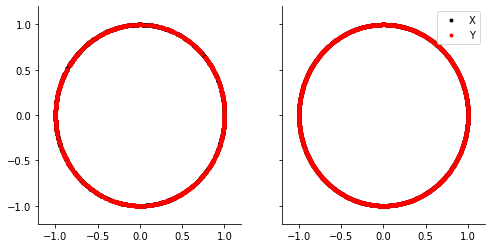

In [11]:
# values for training
pairs = np.zeros((dict_size,2,2))
# generate data on a circle, 
alpha = []
while len(alpha)<dict_size:
    i = np.random.rand(1)
    if i<=1:
        alpha.extend(i)
alpha = np.array(alpha)
z = np.exp(2*np.pi*1j*alpha)
a = z.real
b = z.imag
pairs[:,0,0],pairs[:,0,1] = a,b
alpha = alpha + np.random.choice((-1,1))*np.random.choice(np.arange(1/10,1/2,.01),dict_size)
z = np.exp(2*np.pi*1j*(alpha)) #np.exp(2*np.pi*1j*(alpha+1/4)) # make second stimulus orthogonal
a = z.real
b = z.imag
pairs[:,1,0],pairs[:,1,1] = a,b

# values for testing
pairs_test = np.zeros((dict_size,2,2))
alpha = np.arange(0,1,1/dict_size)
z = np.exp(2*np.pi*1j*alpha)
a = z.real
b = z.imag
pairs_test[:,0,0],pairs_test[:,0,1] = a,b
alpha = alpha + 1/4#np.random.choice(np.arange(1/6,1/4,.01),dict_size)
z = np.exp(2*np.pi*1j*(alpha))
a = z.real
b = z.imag
pairs_test[:,1,0],pairs_test[:,1,1] = a,b

# values for validation
pairs_val = np.zeros((dict_size,2,2))
alpha = np.random.rand(dict_size)
z = np.exp(2*np.pi*1j*alpha)
a = z.real
b = z.imag
pairs_val[:,0,0],pairs_val[:,0,1] = a,b
z = np.exp(2*np.pi*1j*(alpha+1/4))
a = z.real
b = z.imag
pairs_val[:,1,0],pairs_val[:,1,1] = a,b
# visualize stimuli
# training

fig,ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
ax[0].plot(pairs[:,0,0],pairs[:,0,1],'k.')
ax[0].plot(pairs[:,1,0],pairs[:,1,1],'r.')
ax[1].plot(pairs_test[:,0,0],pairs_test[:,0,1],'k.')
ax[1].plot(pairs_test[:,1,0],pairs_test[:,1,1],'r.')
plt.tight_layout
ax[0].set_xlim(-1.2,1.2)
ax[0].set_ylim(-1.2,1.2)
plt.legend(('X','Y'))
sb.despine()
plt.savefig('NIP_inputs.png')
plt.show()

In [ ]:


# produce random stimulus pairs:
#dictionary = np.random.randn(dict_size,input_size)
#pairs = np.random.randn(dict_size,2,input_size) 
#pairs_val = np.random.randn(dict_size,2,input_size)
#pairs_test = np.random.randn(dict_size,2,input_size)
#pairs_test_samestim = pairs.copy()[np.random.permutation(pairs.shape[0]),:] # shuffle pairs from trained stimuli
zero_vector = np.random.randn(1,input_size) # this is used for the zero state
all_stimuli = np.concatenate((pairs_test,np.repeat(zero_vector[None,:],dict_size,0)),1)
#all_stimuli_samestim = np.concatenate((np.reshape(pairs_test_samestim,(pairs.shape[0]*2,input_size)),zero_vector),0)
#nstim = all_stimuli.shape[0]
    
# create training and test data
sequence = make_sequence(seq,repeats,pairs,zero_vector,deviance_prob) # training sequences, 10 repeats
sequence_2 = make_sequence(seq,repeats-3,pairs,zero_vector,deviance_prob)
# add all together
sequence.append(sequence_2)

test_sequence = make_sequence(seq_test,repeats,pairs_test,zero_vector,0)
test_sequence2 = make_sequence(seq_test2,2,pairs_test,zero_vector,0) # 
# concatenate both test sequences
for i in range(len(seq_test)):
    test_sequence[i] = np.concatenate((test_sequence[i],test_sequence2[i]),1)

# test sequence with one repeat less
test_sequence_2 = make_sequence(seq_test,repeats-1,pairs_test,zero_vector,0)
test_sequence2_2 = make_sequence(seq_test2,2,pairs_test,zero_vector,0)
# concatenate both test sequences
for i in range(len(seq_test)):
    test_sequence_2[i] = np.concatenate((test_sequence_2[i],test_sequence2_2[i]),1)
    
val_sequence = make_sequence(seq,repeats,pairs_val,zero_vector,0)
#test_sequence_samestim = make_sequence(seq_test,repeats,pairs_test_samestim,zero_vector,0)
#test_sequence2_samestim = make_sequence(seq_test2,2,pairs_test_samestim,zero_vector,0)

    #test_sequence_samestim[i] = np.concatenate((test_sequence_samestim[i],test_sequence2_samestim[i]),1)


print('%s units per layer, %s layer'%(n_hidden,n_layers))

# make torch variables
train_x = []
train_y = []
val_x = []
val_y = []
for i in range(len(seq)):
    #trainind = np.delete(np.arange(ntrials),k)
    train_x.append(torch.Tensor(sequence[i][:,:-1,:])) #!!-1 if no zero element after each chunk, otherwise -2
    train_y.append(torch.Tensor(sequence[i][:,1:,:])) 
    val_x.append(torch.Tensor(val_sequence[i][:,:-1,:]))
    val_y.append(torch.Tensor(val_sequence[i][:,1:,:]))
    
## train network
model = RNN(n_hidden,n_layers,input_size,p_dropout)
Loss = train_model(train_x,train_y, val_x,val_y,model)


# evaluation
Acc, AngleAll,Angle, Yhat, Ytrue, Hidden, Hidden_2 = [],[],[],[],[],[],[]
print('Evaluate...')
for i in range(Nseq):
    Nback = 3*len(seq_test[i]) + 3 # predict last N=LENGTH*3 items of sequence; + 3 for zero states
    
    # pre-allocate
    Acc.append(np.zeros((Nback,dict_size)))

    AngleAll.append(np.zeros((Nback,dict_size,3)))
    Angle.append(np.zeros((Nback,dict_size)))
    Yhat.append(np.zeros((dict_size,Nback,input_size))) # store prediction here
    Ytrue.append(np.zeros((dict_size,Nback,input_size))) # store ground truth
    #Yhat_samestim.append(np.zeros((pairs.shape[0],Nback,input_size)) )# store prediction here
    #Ytrue_samestim.append(np.zeros((pairs.shape[0],Nback,input_size)) )# store ground truth
    Hidden.append(np.zeros((dict_size,Nback,n_hidden)) )# hidden state activity
    Hidden_2.append(np.zeros((dict_size,Nback,n_hidden)) )
    #Hidden_samestim.append(np.zeros((pairs.shape[0],Nback,n_hidden)))

    
    test_x = []
    for j in range(Nback):
        if j==Nback-1:
            test_x.append(torch.Tensor(test_sequence[i]))
        else:
            test_x.append(torch.Tensor(test_sequence[i][:,:-Nback+j+1 ,:]))

    y,h = predict(test_x,model)

    for j in range(Nback):
        Yhat[i][:,j,:] = y[j]
        if j==Nback-1:
            Ytrue[i][:,j,:] = test_sequence[i][:,-Nback,:]
        else:
            Ytrue[i][:,j,:] = test_sequence[i][:,-Nback+j+1 ,:] # last item is zero state
        Hidden[i][:,j,:] = h[j][0].detach().numpy()
    
    
    test_x = []
    for j in range(Nback):
        if j==Nback-1:
            test_x.append(torch.Tensor(test_sequence_2[i]))
        else:
            test_x.append(torch.Tensor(test_sequence_2[i][:,:-Nback+j+1 ,:]))

    y,h = predict(test_x,model)

    for j in range(Nback):
        Hidden_2[i][:,j,:] = h[j][0].detach().numpy()
        
    # compute angles and accuracy
    print('Compute accuracy sequence %s'%seq_test[i])
    for j in range(Nback): # items in sequence
        for k in range(dict_size):
            
            # test sequences
            yhat = Yhat[i][k,j,:]
            ytrue = Ytrue[i][k,j,:]
            yrep = np.repeat(ytrue[None,:],3,0)
            target_idx = np.argmin(np.mean(abs(yrep-all_stimuli[k,:]),1))

            # angle with all vectors
            ynorm = yhat/np.linalg.norm(yhat)
            dic = np.array([all_stimuli[k,u,:]/np.linalg.norm(all_stimuli[k,u,:]) for u in range(3)])
            for s in range(3):
                AngleAll[i][j,k,s] = np.arccos(ynorm@dic[s,:]) * 180/np.pi
            # angle with correct vector
            Angle[i][j,k] = AngleAll[i][j,k,target_idx]
            Acc[i][j,k] = np.argmin(AngleAll[i][j,k,:])==target_idx
            #Acc10[i][j,k] = target_idx in np.argsort(AngleAll[i][j,k,:])[:10]

for i in range(Nseq):
    mean_acc = np.mean(Acc[i][len(seq_test[i])-2,:])
    #mean_acc10 = np.mean(Acc10[i][len(seq_test[i])-2,:])
    print('New stimuli; Accuracy for last in sequence %s: %.3f'%(seq_test[i],mean_acc))
    


128 units per layer, 1 layer


In [85]:
zero_vector.shape

(2, 1)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
colors = [[0,.3,.8],[0.8,0,0],[0,.6,.8],[0.8,.3,0]]
for i in range(Nseq):
    plt.plot(np.mean(Acc[i][:5,:],-1),'.-',label=seq_test[i],color=colors[i])
plt.legend(bbox_to_anchor=(1.1,1.1))

plt.ylim(.3,1)
sb.despine()
ax.set_xticks(np.arange(5))
ticks = [1,2,3,4,'zero']
ax.set_xticklabels(ticks)
ax.set_xlabel('Item')
plt.ylabel('Accuracy')
plt.tight_layout()
#plt.savefig('NIP_Accuracy')

plt.show()

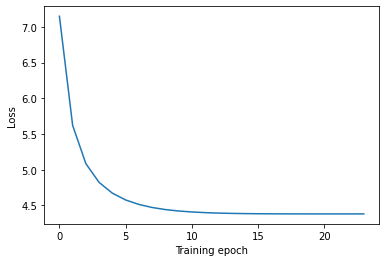

In [39]:
plt.plot(Loss)

plt.ylabel('Loss')
plt.xlabel('Training epoch')
#plt.savefig('NIP_validationLoss.png')
plt.show()

## Stimulus representation
(only for circular input)

(-4.0, 4.0)

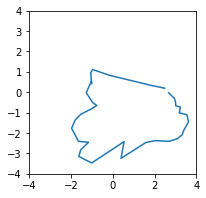

In [40]:
import math
from sklearn.decomposition import PCA
stimuli = []
responses = []
for i in range(Nseq):
    stimuli.append(np.reshape(test_sequence[i][:,-Nback:-Nback+5,:],(dict_size*5,input_size)))
    responses.append(np.reshape(Hidden[i][:,:5,:],(dict_size*5,n_hidden)))
stimuli = np.concatenate(stimuli)
responses = np.concatenate(responses)
angles = np.zeros(stimuli.shape[0])
for i in range(stimuli.shape[0]):
    angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
# bin the angles
binsize = 10
bins = np.arange(-180,180,binsize)
responses_binned = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
responses_binned = responses_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0) / np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)

# regression
S = np.eye(len(bins))
Beta = responses_binned.T@S
# PCA
pca = PCA(n_components=2)
pca.fit(Beta.T)
comp = pca.components_
# project single trials onto axes
responses_pc = responses@comp.T
responses_binned_pc = np.zeros((len(bins),2))
fig,ax = plt.subplots(1,1,figsize=(3,3))
for i,b in enumerate(bins):
    responses_binned_pc[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)


plt.plot(responses_binned_pc[:,0],responses_binned_pc[:,1],'-')
plt.xlim(-4,4)
plt.ylim(-4,4)

### Visualize results

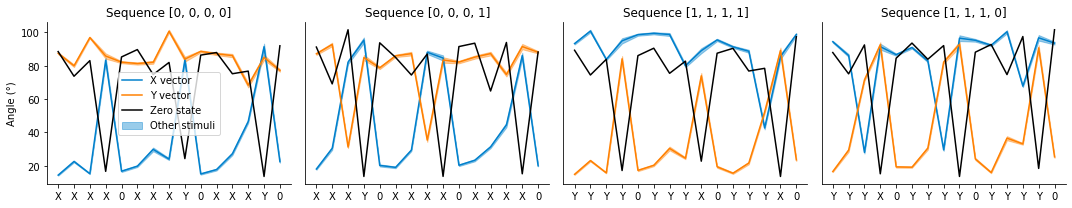

In [1209]:
# PLOT ANGLE FOR EACH STIMULUS X WITH ITS CORRESPONDING VECTOR AND THE OTHER VECTOR Y
xlabels = ['X','Y','Z','0'] # for correct x ticks


test_seq = []
for i in range(len(seq_test)):
    test_seq.append(np.concatenate((seq_test[i],[3],seq_test2[i],[3],seq_test2[i],[3]))) 
    # this is the sequence evaluated in the previous cell

    
# FOR NEW STIMULI
TargetResp = []
SmallestResp = []
for which_seq in range(Nseq): # loop through sequences
    Nback = len(seq_test[which_seq])*3 + 3
    TargetResp.append(np.zeros((Nback,pairs_test.shape[0],3)))
    #SmallestResp.append(np.zeros((Nback,pairs_test.shape[0])))
    for stimulus in range(pairs_test.shape[0]): # loop through all stimuli
        for i in range(3):                
            TargetResp[which_seq][:,stimulus,i] = AngleAll[which_seq][:,stimulus,i]
        # get vector closest to the selected but first three
        #SmallestResp[which_seq][:,stimulus] = np.sort(np.delete(AngleAll[which_seq][:,stimulus,:],(stimulus*2,stimulus*2+2,stimulus*2+1),-1),-1)[:,int(dict_size*0.1)]
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0],[0,0,0]]
for which_seq in range(Nseq):
    N = len(seq_test[which_seq])*3 + 3
    for i in range(2):
        m = np.mean(TargetResp[which_seq][:,:,i],1)
        sem = np.std(TargetResp[which_seq][:,:,i],1)/np.sqrt(pairs.shape[0])
        ax[which_seq].plot(np.arange(N),m,color=col[i])
        ax[which_seq].fill_between(np.arange(N),m-sem,m+sem,color=col[i],alpha=.4)
    m = np.mean(AngleAll[which_seq][:,:,-1],1)
    ax[which_seq].plot(np.arange(N),m,color=[0,0,0])
    #m = np.min(AngleAll[which_seq][:,:,:,],1)
    #ax[which_seq].plot(np.arange(N),SmallestResp[which_seq],color=[.8,.8,.8],alpha=.5)
    ax[which_seq].spines['right'].set_visible(False)
    ax[which_seq].spines['top'].set_visible(False)
    ax[which_seq].set_title('Sequence %s'%seq_test[which_seq])
    ax[which_seq].set_xticks(np.arange(N))
    ticks = []
    for t in range(N):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('Angle (°)')
    ax[0].legend(['X vector','Y vector','Zero state','Other stimuli'])
plt.tight_layout()
#plt.savefig('NIP_Angles_local-global_circular.pdf')
#plt.savefig('NIP_Angles_local-global_circular.png')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


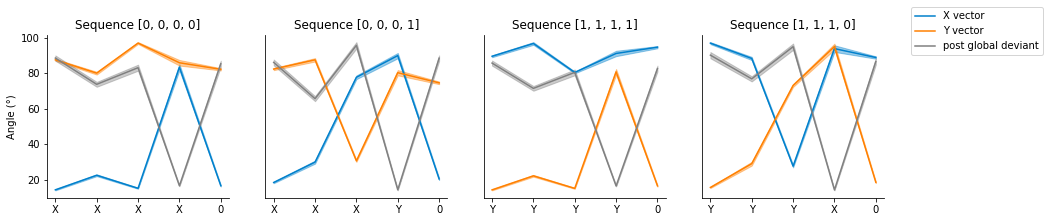

In [1210]:
# overlay global standard and post-global deviant
fig,ax = plt.subplots(1,Nseq,figsize=(15,3))
col = [[0,.5,.8],[1,.5,0],[0.5,0.5,0.5]]
markers = ['-','--']
for which_seq in range(Nseq):
    N = len(seq_test[which_seq]) + 1
    for n,step in enumerate([0]):
        for i in range(3):
        
            m = np.mean(TargetResp[which_seq][5*step:5*(step+1),:,i],1)
            sem = np.std(TargetResp[which_seq][5*step:5*(step+1),:,i],1)/np.sqrt(pairs.shape[0])
            ax[which_seq].plot(np.arange(5),m,color=col[i],linestyle=markers[n])
            ax[which_seq].fill_between(np.arange(5),m-sem,m+sem,color=col[i],alpha=.4)
        #m = np.mean(np.mean(TargetResp[which_seq,:,:,:,5*n:5*(n+1)],2),1).T
        #ax[which_seq].plot(np.arange(5),m,color=[.8,.8,.8],alpha=.5)
    ax[which_seq].set_xticks(np.arange(5))
    ax[which_seq].spines['right'].set_visible(False)
    ax[which_seq].spines['top'].set_visible(False)
    ax[which_seq].set_title('Sequence %s'%seq_test[which_seq])
    ticks = []
    for t in range(5):
        ticks.append(xlabels[test_seq[which_seq][t]])
    ax[which_seq].set_xticklabels(ticks)
    if which_seq>0:
        ax[which_seq].set_yticks(())
    ax[0].set_ylabel('Angle (°)')
    ax[0].legend(['X vector','Y vector','post global deviant'],bbox_to_anchor=(5.5,1.2))
plt.tight_layout()
plt.savefig('NIP_Angles_circular.pdf')
plt.savefig('NIP_Angles_cicular.png')

plt.show()

### PCA with global deviants

In [117]:
n_comp = 10

# get all hidden activations from the different sequences
n_pos = 15 # until this item position
AllHidden = np.zeros((pairs.shape[0],Nseq,n_pos,n_hidden))
Proj = []
Varexp = np.zeros((Nseq,pairs.shape[0],n_comp))
PCs = np.zeros((Nseq,pairs.shape[0],n_comp,n_hidden))
AllHidden = []
for s in range(4):
    AllH = []
    for s2 in range(1):
        AllH.append(Hidden[s+s2*1][:,:n_pos,:])
        Proj.append(np.zeros((pairs.shape[0],Hidden[s].shape[1],n_comp))) # pre-allocate
    AllHidden.append(np.concatenate(AllH,1))
for s in range(4):    
    # perform one PC for every pair
    for i in range(pairs.shape[0]):
        hidden = AllHidden[s][i,:]
        principal = PCA(n_components = n_comp)
        principal.fit(hidden)
        # project
        for s2 in range(1):
            hidden = Hidden[s+s2*1][i,:]
            x = principal.transform(hidden)
            Proj[s+1*s2][i,:,:] = x
            Varexp[s+1*s2,i,:]  = principal.explained_variance_ratio_
            PCs[s+1*s2,i,:,:] = principal.components_

In [166]:
n_comp = 10
Nseq = 4
# get all hidden activations from the different sequences
n_pos = 5 # until this item position
AllHidden = np.zeros((pairs.shape[0],Nseq,n_pos,n_hidden))
Proj = []
for s in range(Nseq):
    AllHidden[:,s,:] = Hidden[s][:,:n_pos,:]
    Proj.append(np.zeros((pairs.shape[0],Hidden[s].shape[1],n_comp))) # pre-allocate
# reshape for PCA
AllHidden = np.reshape(AllHidden,(pairs.shape[0],Nseq*n_pos,n_hidden))

Varexp = np.zeros((pairs.shape[0],n_comp))
PCs = np.zeros((pairs.shape[0],n_comp,n_hidden))
# perform one PC for every pair
for i in range(pairs.shape[0]):
    hidden = AllHidden[i,:10,:]
    principal = PCA(n_components = n_comp)
    principal.fit(hidden)
    # project
    for s in range(Nseq):
        hidden = Hidden[s][i,:]
        x = principal.transform(hidden)
        Proj[s][i,:,:] = x
    Varexp[i,:]  = principal.explained_variance_ratio_
    PCs[i,:,:] = principal.components_

In [416]:
Proj[0].shape

(100, 15, 10)

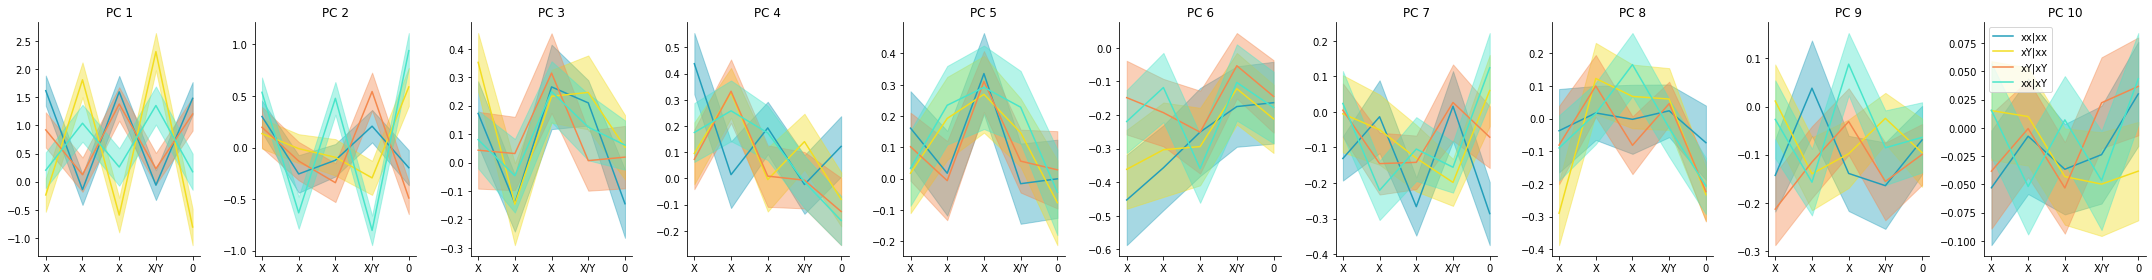

In [167]:
# visualize global standards and errors
ticks = ['X','X','X','X/Y','0']
colors = [['#229eba','#f2dd20'], # xx block
         ['#f4884d','#48e5ca']] # xY block
labels = [['xx|xx','xY|xx'],['xY|xY','xx|xY']]

plot_comp = 10
fig,ax = plt.subplots(1,plot_comp,figsize=(plot_comp*3,4))
for c in range(plot_comp):
    for s in range(2):
        for j in range(2):
            m = np.mean(Proj[s+2][:,j*5:(j+1)*5,c],0)
            sem = np.std(Proj[s+2][:,j*5:(j+1)*5,c],0)/np.sqrt(pairs.shape[0])
            ax[c].plot(np.arange(5),m,color=colors[s][j],label=labels[s][j])
            ax[c].fill_between(np.arange(5),m-sem,m+sem,color=colors[s][j],alpha=.4)
    ax[c].set_xticks(np.arange(5))
    ax[c].set_xticklabels(ticks)
    ax[c].set_title('PC %s'%(c+1))
    ax[c].spines['top'].set_visible(False)
    ax[c].spines['right'].set_visible(False)
plt.tight_layout()
plt.legend()
#plt.savefig('NIP_PCA_Trialtypes.pdf')
#plt.savefig('NIP_PCA_Trialtypes.png')
plt.show()

# Decoding

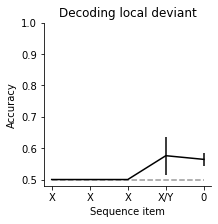

In [18]:
from sklearn.linear_model import LogisticRegression
n_batch = 4 #dict_size
batchsize = int(dict_size/n_batch)
n_pos = 5
# leave one out cross validation
ScoreHidden = np.zeros((n_batch,n_pos))
CoefLocal = np.zeros((n_batch,n_pos,n_hidden))
for seq_pos in range(n_pos):

    
    for i in range(n_batch):
        testind = (np.arange((1/4*dict_size)*i+(1/2*dict_size),(1/4*dict_size)*i+(3/4*dict_size),1)).astype(int) #[i]
        ind = (np.arange((1/4*dict_size)*i,(1/4*dict_size)+(1/4*dict_size)*(i))).astype(int) #np.delete(np.arange(dict_size),testind)
        testind[testind>=dict_size] = testind[testind>=dict_size] - 5/4 * dict_size
        ytrain = np.concatenate((np.ones(4*len(ind)),np.zeros(4*len(ind))))
        ytest = np.concatenate((np.ones(4*len(testind)),np.zeros(4*len(testind))))

        #### DECODE FROM ALL HIDDEN UNITS
        
        Xtrain = Hidden[1][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[2][ind,seq_pos+5,:]),0)
        # add local standard sequences
        Xtrain = np.concatenate((Xtrain,Hidden[0][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = Hidden[1][testind,seq_pos,:]
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[0][testind,seq_pos+5,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[2][testind,seq_pos+5,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[0][testind,seq_pos,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[1][testind,seq_pos+5,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos+5,:]),0)
        reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScoreHidden[i,seq_pos] = reg_local.score(Xtest,ytest)
        CoefLocal[i,seq_pos,:] = reg_local.coef_
        
fig,ax = plt.subplots(1,1,figsize=(3,3))
ticks = ['X','X','X','X/Y','0']
ax.errorbar(np.arange(n_pos),np.mean(ScoreHidden,0),yerr=np.std(ScoreHidden,0)/np.sqrt(n_batch),color='k',label='Hidden units')
#ax.errorbar(np.arange(n_pos),np.mean(ScorePC,0),yerr=np.std(ScorePC,0)/np.sqrt(np.sqrt(n_stim)),color=[.9,0,.4],label='%s first PCs'%n_comp)
ax.plot(np.arange(n_pos),np.ones(n_pos)*.5,'k--',alpha=.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding local deviant')
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_xlabel('Sequence item')
ax.set_ylim(.48,1)
#ax.set_ylim(.48,1)
plt.savefig('NIP_Decoding_Local_generalization.png')
plt.savefig('NIP_Decoding_Local_generalization.pdf')
plt.show()# 



ValueError: x and y must have same first dimension, but have shapes (36,) and (16,)

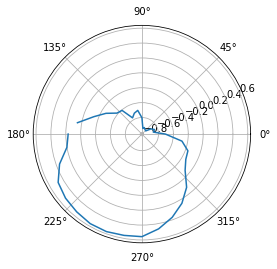

In [1212]:
coef = np.mean(CoefLocal[:,3],0)
ind = np.argsort(coef)
indabs = np.argsort(abs(coef))


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,responses_binned[:,ind[-1]])
plt.plot((bins)*np.pi/180,responses_dev_binned[:,ind[-1]],color='r')
plt.show()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,responses_binned[:,ind[-2]])
plt.plot((bins)*np.pi/180,responses_dev_binned[:,ind[-2]],color='r')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,responses_binned[:,indabs[0]])
plt.plot((bins)*np.pi/180,responses_dev_binned[:,indabs[0]],color='r')
plt.show()
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,responses_binned[:,indabs[1]])
plt.plot((bins)*np.pi/180,responses_dev_binned[:,indabs[1]],color='r')
plt.show()


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,np.mean(TCstnd,0))
plt.plot((bins)*np.pi/180,np.mean(TCdev,0),color='r')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,np.mean(TCstnd[ind[-int(n_hidden*0.1):],:],0))
plt.plot((bins)*np.pi/180,np.mean(TCdev[ind[-int(n_hidden*0.1):],:],0),color='r')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,np.mean(TCstnd[ind[:int(n_hidden*0.1)],:],0))
plt.plot((bins)*np.pi/180,np.mean(TCdev[ind[:int(n_hidden*0.1)],:],0),color='r')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot((bins)*np.pi/180,np.mean(TCstnd[indabs[:int(n_hidden*0.1)],:],0))
plt.plot((bins)*np.pi/180,np.mean(TCdev[indabs[:int(n_hidden*0.1)],:],0),color='r')
plt.show()

### Decode global

In [816]:
Xtest.shape

(8, 250, 128)

In [815]:
from sklearn.linear_model import LogisticRegression
n_pos = 5
# leave one out cross validation
#ScorePC = np.zeros((dict_size,n_pos))
ScoreHidden = np.zeros((n_batch,n_pos))
PredProb = np.zeros((n_batch,n_pos,8))
#Coef = np.zeros((dict_size,n_pos,n_comp))

ytrain = np.concatenate((np.zeros(4*len(ind)),np.ones(4*len(ind))))
ytest = np.concatenate((np.zeros(4),np.ones(4)))
for seq_pos in range(n_pos):

    
    for i in range(n_batch):
        testind = (np.arange((1/4*dict_size)*i+(1/2*dict_size),(1/4*dict_size)*i+(3/4*dict_size),1)).astype(int) #[i]
        ind = (np.arange((1/4*dict_size)*i,(1/4*dict_size)+(1/4*dict_size)*(i))).astype(int) #np.delete(np.arange(dict_size),testind)
        testind[testind>=dict_size] = testind[testind>=dict_size] - 5/4 * dict_size
        ytrain = np.concatenate((np.ones(4*len(ind)),np.zeros(4*len(ind))))
        ytest = np.concatenate((np.ones(4),np.zeros(4)))
        # local deviant items, 

    
        ### DECODE FROM ALL HIDDEN UNITS
        Xtrain = Hidden[0][ind,seq_pos,:]
        Xtrain = np.concatenate((Xtrain,Hidden[1][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[2][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden[3][ind,seq_pos,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[0][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[1][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[2][ind,seq_pos+5,:]),0)
        Xtrain = np.concatenate((Xtrain,Hidden_2[3][ind,seq_pos+5,:]),0)
        # for test data
        Xtest = Hidden[0][testind,seq_pos,:][None,:]
        Xtest = np.concatenate((Xtest,Hidden[1][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[2][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden[3][testind,seq_pos,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[0][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[1][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[2][testind,seq_pos+5,:][None,:]),0)
        Xtest = np.concatenate((Xtest,Hidden_2[3][testind,seq_pos+5,:][None,:]),0)
        reg = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
        ScoreHidden[i,seq_pos] = reg.score(Xtest,ytest)
        PredProb[i,seq_pos,:] = reg.predict_proba(Xtest)[:,1]
        
fig,ax = plt.subplots(1,1,figsize=(3,3))
ticks = ['X','X','X','X/Y','0']
ax.errorbar(np.arange(n_pos),np.mean(ScoreHidden,0),yerr=np.std(ScoreHidden,0)/np.sqrt(dict_size),color='k',label='Hidden units')
#ax.errorbar(np.arange(n_pos),np.mean(ScorePC,0),yerr=np.std(ScorePC,0)/np.sqrt(np.sqrt(n_stim)),color=[.9,0,.4],label='%s first PCs'%n_comp)
ax.plot(np.arange(n_pos),np.ones(n_pos)*.5,'k--',alpha=.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding global deviant')
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_xlabel('Sequence item')
ax.set_ylim(.48,1)
#plt.savefig('NIP_Decoding_Global.png')
#plt.savefig('NIP_Decoding_Global.pdf')
plt.show()# 


ValueError: Found array with dim 3. Estimator expected <= 2.

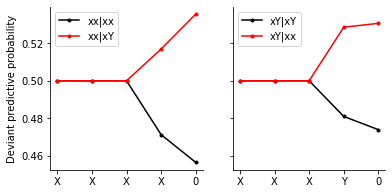

In [642]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(6,3))
# xx
ax[0].plot(np.arange(5),np.mean(np.mean(PredProb[:,:,[0,2]],2),0),'.-k')
ax[0].plot(np.arange(5),np.mean(np.mean(PredProb[:,:,[5,7]],2),0),'.-r')
# xy
ax[1].plot(np.arange(5),np.mean(np.mean(PredProb[:,:,[1,3]],2),0),'.-k')
ax[1].plot(np.arange(5),np.mean(np.mean(PredProb[:,:,[4,6]],2),0),'.-r')
ax[0].set_ylabel('Deviant predictive probability')
ax[0].legend(['xx|xx','xx|xY'])
ax[1].legend(['xY|xY','xY|xx'])
ticks = ['X','X','X','X','0']
ax[0].set_xticks(np.arange(n_pos))
ax[0].set_xticklabels(ticks)
ticks = ['X','X','X','Y','0']
ax[1].set_xticks(np.arange(n_pos))
ax[1].set_xticklabels(ticks)
sb.despine()
plt.savefig('NIP_Decoding_Global_prob.png')
plt.savefig('NIP_Decoding_Global_prob.pdf')

plt.show()

Context

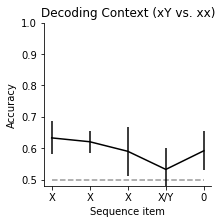

In [19]:
n_stim = dict_size
n_pos = 5
# leave one out cross validation
ScoreHidden = np.zeros((n_batch,n_pos))
ScoreAllHidden = np.zeros((n_batch,repeats))
CoefContext = np.zeros((n_batch,n_hidden))

# get all activations (0-10 chunks):
model.eval()
AllHidden = np.zeros((Nseq,dict_size,repeats*n_pos,n_hidden))
n_layers = len(model.hidden)
for s in range(Nseq):
    h = {}
    for k in range(n_layers):
        h[k] = torch.zeros((dict_size,n_hidden))
    for i in range(repeats*n_pos):
        x = test_sequence[s][:,i,:]
        _,h = model(torch.Tensor(x),h)
        AllHidden[s,:,i,:] = h[0].detach().numpy() 
            
    


for i in range(n_batch):
    testind = (np.arange((1/4*dict_size)*i+(1/2*dict_size),(1/4*dict_size)*i+(3/4*dict_size),1)).astype(int) #[i]
    ind = (np.arange((1/4*dict_size)*i,(1/4*dict_size)+(1/4*dict_size)*(i))).astype(int) #np.delete(np.arange(dict_size),testind)
    testind[testind>=dict_size] = testind[testind>=dict_size] - 5/4 * dict_size
    ytrain = np.concatenate((np.ones(2*len(ind)*3),np.zeros(2*len(ind)*3)))
    ytest = np.concatenate((np.ones(2*len(testind)),np.zeros(2*len(testind))))
    ytest_chunk = np.concatenate((np.ones(2*3),np.zeros(2*3)))
    #### DECODE FROM ALL HIDDEN UNITS
        
    # xy block
    Xtrain = np.reshape(Hidden[1][ind,:3,:],(len(ind)*3,n_hidden))
    Xtrain = np.concatenate((Xtrain,np.reshape(Hidden[3][ind,:3,:],(len(ind)*3,n_hidden))),0)

    # add xx
    Xtrain = np.concatenate((Xtrain,np.reshape(Hidden[0][ind,:3,:],(len(ind)*3,n_hidden))),0)
    Xtrain = np.concatenate((Xtrain,np.reshape(Hidden[2][ind,:3,:],(len(ind)*3,n_hidden))),0) 
      
    # for test data
    Xtest = Hidden[1][testind,:n_pos,:]
    Xtest = np.concatenate((Xtest,Hidden[3][testind,:n_pos,:]),0)
    Xtest = np.concatenate((Xtest,Hidden[0][testind,:n_pos,:]),0)
    Xtest = np.concatenate((Xtest,Hidden[2][testind,:n_pos,:]),0)
    
    reg = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
    for seq_pos in range(n_pos):
        ScoreHidden[i,seq_pos] = reg.score(Xtest[:,seq_pos,:],ytest)
    CoefContext[i,:] = reg.coef_
    
    # additionally train and evaluate on all sequence chunks (average of first three items)
    ytrain = np.concatenate((np.ones(2*len(ind)),np.zeros(2*len(ind))))
    for r in range(repeats):
        # xy
        if r==0:
            Xtrain = np.mean(AllHidden[1,ind,r*n_pos:r*n_pos+3,:],1)
        else:
            Xtrain = np.concatenate((Xtrain,np.mean(AllHidden[1,ind,r*n_pos:r*n_pos+3,:],1)),0)
        Xtrain = np.concatenate((Xtrain,np.mean(AllHidden[3,ind,r*n_pos:r*n_pos+3,:],1)),0)
    
        # add xx
        Xtrain = np.concatenate((Xtrain,np.mean(AllHidden[0,ind,r*n_pos:r*n_pos+3,:],1)),0)
        Xtrain = np.concatenate((Xtrain,np.mean(AllHidden[2,ind,r*n_pos:r*n_pos+3,:],1)),0) 
        if r>0:
            ytrain = np.concatenate((ytrain,np.ones(2*len(ind)),np.zeros(2*len(ind))))

    reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
    
    for r in range(repeats):   
        Xtest = np.mean(AllHidden[1,testind,r*n_pos:r*n_pos+3,:],1)
        Xtest = np.concatenate((Xtest,np.mean(AllHidden[3,testind,r*n_pos:r*n_pos+3,:],1)),0)
        Xtest = np.concatenate((Xtest,np.mean(AllHidden[0,testind,r*n_pos:r*n_pos+3,:],1)),0)
        Xtest = np.concatenate((Xtest,np.mean(AllHidden[2,testind,r*n_pos:r*n_pos+3,:],1)),0)
        ScoreAllHidden[i,r] = reg_local.score(Xtest,ytest)
        
        
fig,ax = plt.subplots(1,1,figsize=(3,3))
ticks = ['X','X','X','X/Y','0']
ax.errorbar(np.arange(n_pos),np.mean(ScoreHidden,0),yerr=np.std(ScoreHidden,0)/np.sqrt(n_batch),color='k',label='Hidden units')
#ax.errorbar(np.arange(n_pos),np.mean(ScorePC,0),yerr=np.std(ScorePC,0)/np.sqrt(np.sqrt(n_stim)),color=[.9,0,.4],label='%s first PCs'%n_comp)
ax.plot(np.arange(n_pos),np.ones(n_pos)*.5,'k--',alpha=.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding Context (xY vs. xx)')
ax.set_xticks(np.arange(n_pos))
ax.set_xticklabels(ticks)
ax.set_xlabel('Sequence item')
ax.set_ylim(.48,1)
plt.savefig('NIP_Decoding_Context_generalization.png')
plt.savefig('NIP_Decoding_Context_generalization.pdf')
plt.show()# 


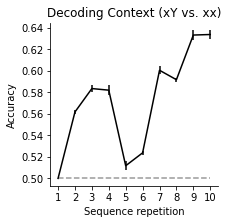

In [20]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
plt.errorbar(x=np.arange(repeats), y=np.mean(ScoreAllHidden,0),yerr=np.std(ScoreAllHidden,0)/np.sqrt(dict_size),color='k')
ax.plot(np.arange(repeats),np.ones(repeats)*.5,'k--',alpha=.4)
ax.set_ylabel('Accuracy')
ax.set_title('Decoding Context (xY vs. xx)')
ax.set_xticks(np.arange(repeats))
ax.set_xticklabels(np.arange(repeats)+1)
ax.set_xlabel('Sequence repetition')
#ax.set_ylim(.48,1)
sb.despine()
#plt.savefig('NIP_Decoding_Context_repeats.png')
#plt.savefig('NIP_Decoding_Context_repeats.pdf')
plt.show()# 

In [1215]:
plt.plot(np.arange(5),np.median(Hidden[0][:,:5,ind[-1]],0),'b')
plt.plot(np.arange(5),np.median(Hidden[2][:,:5,ind[-1]],0),'b')
plt.plot(np.arange(5),np.median(Hidden_2[0][:,5:10,ind[-1]],0),'r')
plt.plot(np.arange(5),np.median(Hidden_2[2][:,5:10,ind[-1]],0),'r')


IndexError: index 999 is out of bounds for axis 2 with size 128

Ordinal position


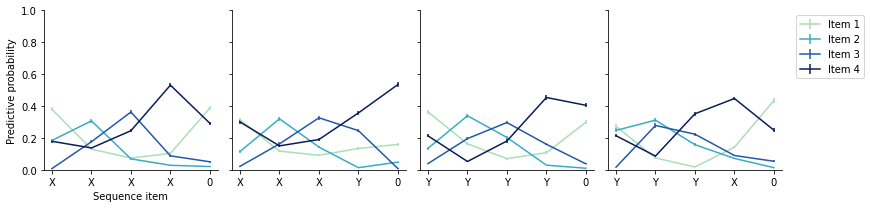

In [21]:
from matplotlib import cm
seq = 0
count = [0,1,2,3]
cmap = cm.get_cmap('YlGnBu')
item_colors = cmap(np.linspace(0.3,1,4))
######## leave one stimulus out cross-validation
Acc = np.zeros((dict_size,Nseq))
Prob = np.zeros((dict_size,Nseq,n_pos,max(count)+1))
for i in range(n_batch): # n_pairs
    testind = (np.arange((1/4*dict_size)*i+(1/2*dict_size),(1/4*dict_size)*i+(3/4*dict_size),1)).astype(int) #[i]
    ind = (np.arange((1/4*dict_size)*i,(1/4*dict_size)+(1/4*dict_size)*(i))).astype(int) #np.delete(np.arange(dict_size),testind)
    testind[testind>=dict_size] = testind[testind>=dict_size] - 5/4 * dict_size
    
    Y = []
    X = []
    Ytest = []
    Xtest = []
    
    X = np.reshape(Hidden[seq][ind,:4,:],(len(ind)*4,n_hidden))
    Y = np.reshape(np.repeat(np.arange(4)[:,None],len(ind),1).T,(len(ind)*4))


    reg = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=1000).fit(X,Y)
    
    
    for j in range(Nseq):
        Xtest = Hidden[j][testind,:4,:]#[None,:]
        Ytest = np.arange(4)
        
        for n in range(len(testind)):
            acc = reg.score(Xtest[n,:],Ytest)
            Acc[testind[n],j] = acc
        # get probabilities for each class
        for k in range(n_pos):
            acc = reg.score
            prob = reg.predict_proba(Hidden[j][testind,k,:])
            Prob[testind,j,k,:] = prob
    

fig,ax = plt.subplots(1,Nseq,figsize=(Nseq*3,3),sharey=True)
labels = ['X','Y']
for j in range(Nseq):
    for i in range(4):
        
        ax[j].errorbar(np.arange(n_pos),np.mean(Prob[:,j,:,i],0),np.std(Prob[:,j,:,i],0)/np.sqrt(dict_size),
                   label = "Position %s"%(i+1),color=item_colors[i])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].set_xticks(np.arange(n_pos))
    xticks = []
    for k in range(n_pos):
        if k<n_pos-1:
            xticks.append(labels[seq_test[j][k]])
        else:
            xticks.append('0')
    ax[j].set_xticklabels(xticks)
ax[0].set_ylim(0,1)

ax[0].set_xlabel('Sequence item')
ax[0].set_ylabel('Predictive probability')
#plt.title('Tracking ordinal structure in RNN ')
plt.legend(['Item 1','Item 2','Item 3','Item 4'],bbox_to_anchor=(1.5,1))
plt.tight_layout()
#plt.savefig('NIP_Decoding_PCA_Ordinal_Probas.png')
#plt.savefig('NIP_Decoding_PCA_Ordinal_Probas.pdf')
plt.show()

## Geometry & Tuning

Compute subspace for each sequence type separately

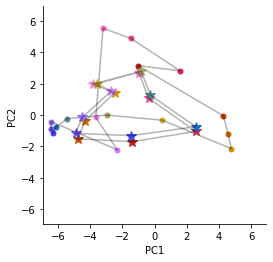

In [41]:
import math
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
data = np.loadtxt("cyclic_colormaps/cyclic_mrybm.txt")
data2 = np.clip(data, 0, 1)
cmap = LinearSegmentedColormap.from_list('my_colormap', data2)

markers = ['.','*']
fig,ax = plt.subplots(1,1,figsize=(4,4))
for k in range(2):


    Nback = 3*len(seq_test[k]) + 3
   
    stimuli = np.concatenate((test_sequence[k][:,-3*5+3,:],test_sequence[k+2][:,-3*5+3,:]),0)
    #responses = np.concatenate((Hidden[k][:,3,:],Hidden[k+2][:,3,:]),0)
    if k==0:
        responses = np.concatenate((Hidden[k][:,3,:],Hidden[k+2][:,3,:]),0)
    else:
        responses = np.concatenate((Hidden_2[0][:,3+5,:],Hidden_2[2][:,3+5,:]),0)
    # centre
    #responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)
    #responses = (responses - np.repeat(np.mean(responses,0)[None,:],dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],dict_size,0)+1*10e-10)

    angles = np.zeros(stimuli.shape[0])
    for i in range(stimuli.shape[0]):
        angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
    # bin the angles
    binsize = 22.5
    bins = np.arange(-180,180,binsize)
    responses_binned = np.zeros((len(bins),n_hidden))
    for i,b in enumerate(bins):
        responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    #responses_binned = responses_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
    
    # regression
    S = np.eye(len(bins))
    Beta = responses_binned.T@S
    nanind = np.where(np.isnan(np.mean(Beta,1)))[0]
    Beta[nanind,:] = 0
    # PCA
    pca = PCA(n_components=2)
    pca.fit(Beta.T)
    comp = pca.components_
    # project single trials onto axes
    responses_pc = responses@comp.T
    proj_responses_binned = np.zeros((len(bins),2))
    for i,b in enumerate(bins):
        proj_responses_binned[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)
        
    proj_responses_binned = np.concatenate((proj_responses_binned,proj_responses_binned[0,:][None,:]),0)
    for i in range(len(bins)):
        plt.plot(proj_responses_binned[i,0],proj_responses_binned[i,1],marker=markers[k],markersize=10,
                 color=cmap(i/len(bins)))
    plt.plot(proj_responses_binned[:,0],proj_responses_binned[:,1],'k',alpha=.3)
    if k==0:
        lim = np.max(abs(proj_responses_binned)) + 0.5
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
sb.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig('NIP_Space_individualspace.png')
#plt.savefig('NIP_Space_individualspace.pdf')
plt.show()

Compute subspace based on XXXX and project XXXY

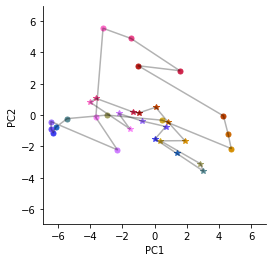

In [42]:
import math
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
data = np.loadtxt("cyclic_colormaps/cyclic_mrybm.txt")
data2 = np.clip(data, 0, 1)
cmap = LinearSegmentedColormap.from_list('my_colormap', data2)

binsize = 22.5
bins = np.arange(-180,180,binsize)
    
stimuli = np.concatenate((test_sequence[0][:,-3*5+3,:],test_sequence[2][:,-3*5+3,:]),0)
responses = np.concatenate((Hidden[0][:,3,:],Hidden[2][:,3,:]),0)

stimuli_dev = np.concatenate((test_sequence_2[0][:,-2*5+3,:],test_sequence_2[2][:,-2*5+3,:]),0)
responses_dev = np.concatenate((Hidden_2[0][:,5+3,:],Hidden[2][:,5+3,:]),0)

stimuli_globdev = np.concatenate((test_sequence[1][:,-2*5+3,:],test_sequence[3][:,-2*5+3,:]),0)
responses_globdev = np.concatenate((Hidden_2[1][:,5+3,:],Hidden_2[3][:,5+3,:]),0)

# centre
#responses_globdev = (responses_globdev - np.repeat(np.mean(responses,0)[None,:],2*dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],2*dict_size,0)+1*10e-10)
#responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],2*dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],2*dict_size,0)+1*10e-10)
#responses = (responses - np.repeat(np.mean(responses,0)[None,:],2*dict_size,0)) / (np.repeat(np.std(responses,0)[None,:],2*dict_size,0)+1*10e-10)

angles = np.zeros(stimuli.shape[0])
angles_dev = np.zeros(stimuli_dev.shape[0])
angles_globdev = np.zeros(stimuli_globdev.shape[0])
for i in range(stimuli.shape[0]):
    angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
    angles_dev[i] = math.degrees(math.atan2(stimuli_dev[i,1], stimuli_dev[i,0]))
    angles_globdev[i] = math.degrees(math.atan2(stimuli_globdev[i,1], stimuli_globdev[i,0]))

# bin the angles
responses_binned = np.zeros((len(bins),n_hidden))
responses_dev_binned = np.zeros((len(bins),n_hidden))
responses_globdev_binned = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_dev_binned[i,:] = np.mean(responses_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)
    responses_globdev_binned[i,:] = np.mean(responses_globdev[(angles_globdev>=b) & (angles_globdev<bins[i]+binsize),:],0)

#responses_dev_binned = (responses_dev_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0)) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
#responses_binned = (responses_binned - np.repeat(np.mean(responses_binned,0)[None,:],len(bins),0)) / (np.repeat(np.std(responses_binned,0)[None,:],len(bins),0)+1*10e-10)
    
# regression
S = np.eye(len(bins))
Beta = responses_binned.T@S

# PCA
pca = PCA(n_components=2)
pca.fit(Beta.T)
comp = pca.components_

# project single trials onto axes
responses_pc = responses@comp.T
responses_pc_dev = responses_dev@comp.T
responses_pc_globdev = responses_globdev@comp.T
proj_responses_binned = np.zeros((len(bins),2))
proj_responses_dev_binned = np.zeros((len(bins),2))
proj_responses_globdev_binned = np.zeros((len(bins),2))
for i,b in enumerate(bins):
    proj_responses_binned[i,:] = np.mean(responses_pc[(angles>=b) & (angles<bins[i]+binsize),:],0)
    proj_responses_dev_binned[i,:] = np.mean(responses_pc_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)
    proj_responses_globdev_binned[i,:] = np.mean(responses_pc_globdev[(angles_globdev>=b) & (angles_globdev<bins[i]+binsize),:],0)
  
fig,ax = plt.subplots(1,1,figsize=(4,4))
proj_responses_dev_binned = np.concatenate((proj_responses_dev_binned,proj_responses_dev_binned[0,:][None,:]),0)
proj_responses_binned = np.concatenate((proj_responses_binned,proj_responses_binned[0,:][None,:]),0)

for i in range(len(bins)):
    plt.plot(proj_responses_binned[i,0],proj_responses_binned[i,1],'.',markersize=10,color=cmap(i/len(bins)))
    plt.plot(proj_responses_dev_binned[i,0],proj_responses_dev_binned[i,1],'*',color=cmap(i/len(bins)))
    #plt.plot(proj_responses_globdev_binned[i,0],proj_responses_globdev_binned[i,1],'.',color=cmap(i/len(bins)))

plt.plot(proj_responses_dev_binned[:,0],proj_responses_dev_binned[:,1],color='k',alpha=.3)
#plt.plot(proj_responses_globdev_binned[:,0],proj_responses_globdev_binned[:,1],color='k',alpha=.3)
plt.plot(proj_responses_binned[:,0],proj_responses_binned[:,1],color='k',alpha=.3)
lim = np.max(abs(proj_responses_binned)) + 0.5
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
sb.despine()
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.savefig('NIP_Space_samespace.png')
#plt.savefig('NIP_Space_samespace.pdf')
plt.show()

#### Tuning

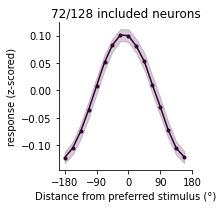

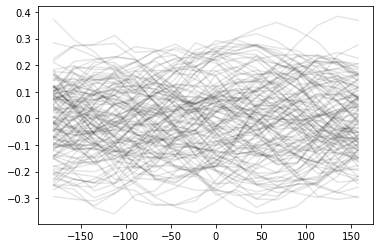

In [57]:
# create data for control block
#N = 1000 # number of trials
#positions = 4#repeats*5
#msc = np.zeros((N,positions,2))
#values = (bins+180)/360
#for i in range(positions):
#    alpha = np.random.choice(values,N)
#    z = np.exp(2*np.pi*1j*alpha)
#    a = z.real
#    b = z.imag
#    msc[:,i,0],msc[:,i,1] = a,b
N = 400
positions = N
batch_size=200
change_probability = 0.5
x_test = np.zeros((batch_size,N,2))
y_test = np.zeros((batch_size,N))
for i in range(N):
    alpha_new = np.random.choice(values,batch_size)
    change = np.random.rand(batch_size)+(change_probability-0.5)
    if i>0:
        alpha_test[np.round(change)==1] = alpha_new[np.round(change)==1]
    else:
        alpha_test = alpha_new
    z = np.exp(2*np.pi*1j*alpha_test)
    a = z.real
    b = z.imag
    x_test[:,i,0],x_test[:,i,1] = a,b
    y_test[:,i] = np.round(change)
    
# get neural network output
n_layers = len(model.hidden)
n_hidden = model.hidden[0].weight.size()[0]
h = {}
for k in range(n_layers):
    h[k] = torch.zeros((N,n_hidden))
#Units = np.zeros((N,positions,n_hidden))
Units = np.zeros((batch_size,N,n_hidden))
for i in range(positions):
    y,h = model(torch.Tensor(msc[:,i,:]),h)
    Units[:,i,:] = h[0].detach().numpy()

Units = np.reshape(Units,(N*positions,n_hidden))

# centre
#Units = (Units - np.repeat(np.mean(Units,0)[None,:],N*positions,0)) / np.repeat(np.std(Units,0)[None,:],N*positions,0)
#Units = (Units - np.repeat(np.mean(responses,0)[None,:],N*positions,0)) / (np.repeat(np.std(responses,0)[None,:],N*positions,0)+1*10e-10)

# get TUNING from many-standard-control
angles = np.zeros((N,positions)) # xy to angle
for i in range(N):
    for j in range(positions):
        angles[i,j] = math.degrees(math.atan2(msc[i,j,1], msc[i,j,0]))
angles[angles==180] = -180
angles = np.reshape(angles,(N*positions))
# bin the angles
responses_binned = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(Units[(np.round(angles,1)>=b) & (np.round(angles,1)<bins[i]+binsize),:],0)

# get preferred 
stimpref = np.argmax(responses_binned,0)

# convert to radiant
bins_rad = bins * np.pi/180
stimpref = bins[stimpref] *np.pi/180

# distance from preferred
stim_distance = np.array([np.angle(np.exp(1j*(bins_rad-stimpref[i]))) for i in range(n_hidden)])
stim_distance[stim_distance==np.pi] = -np.pi

TC = np.zeros((n_hidden,len(bins)))
for n in range(n_hidden):
    for i in range(len(bins)):
        TC[n,i] = np.mean(responses_binned[np.round(stim_distance_stnd[n,:],2)==np.round(bins_rad[i],2),n])

incUnits = np.where((np.mean(TC,1)!=0) & (TC[:,int(len(bins)/2)-1]>TC[:,0]) & (TC[:,int(len(bins)/2)+1]>TC[:,-1]))[0]
fig,ax = plt.subplots(1,1,figsize=(3,3))
plt.plot(bins,np.mean(TC[incUnits,:],0),'.-',color=(0.2,0,0.2),label='Standard')
plt.fill_between(bins,np.mean(TC[incUnits,:],0)-np.std(TC[incUnits,:],0)/np.sqrt(len(incUnits)),
         np.mean(TC[incUnits,:],0)+np.std(TC[incUnits,:],0)/np.sqrt(len(incUnits))
         ,color=(0.2,0,0.2),alpha=.2)
plt.title('%s/%s included neurons'%(len(incUnits),n_hidden))
ax.set_xticks(np.arange(-180,181,90))
sb.despine()
plt.ylabel('response (z-scored)')
plt.xlabel('Distance from preferred stimulus (°)')
#plt.savefig('NIP_tuning.png')
plt.tight_layout()
plt.show()

plt.plot(bins,responses_binned,'k',alpha=0.1)
plt.show()


In [70]:
# create oddball data
blocklength = 200
N = 200 # number of stimuli
oddball = np.zeros((N,blocklength,2))
alpha = np.random.rand(N)
z = np.exp(2*np.pi*1j*alpha)
a = z.real
b = z.imag
z2 = np.exp(2*np.pi*1j*alpha+1/4) # deviant at 90° from standard
a2 = z2.real
b2 = z2.imag
w = np.concatenate([np.round(np.random.rand(1)+.4) for i in range(blocklength)])
for i,ii in enumerate(w):
    if ii==1:
        oddball[:,i,0],oddball[:,i,1] = a, b
    else:
        oddball[:,i,0],oddball[:,i,1] = a2, b2

# get neural network output
n_layers = len(model.hidden)
n_hidden = model.hidden[0].weight.size()[0]
h = {}
for k in range(n_layers):
    h[k] = torch.zeros((N,n_hidden))
Units = np.zeros((N,blocklength,n_hidden))
for i in range(blocklength):
    
    y,h = model(torch.Tensor(oddball[:,i,:]),h)
    Units[:,i,:] = h[0].detach().numpy()

stimuli = np.reshape(oddball[:,w==1,:],(N*sum(w==1),2))
responses = np.reshape(Units[:,w==1,:],(N*sum(w==1),n_hidden))

stimuli_dev = np.reshape(oddball[:,w==0,:],(N*sum(w==0),2))
responses_dev = np.reshape(Units[:,w==0,:],(N*sum(w==0),n_hidden))

stimuli = np.concatenate((test_sequence[0][:,-3*5+3,:],test_sequence[2][:,-3*5+3,:]),0)
responses = np.concatenate((Hidden[0][:,3,:],Hidden[2][:,3,:]),0)

#stimuli_dev = np.concatenate((test_sequence_2[0][:,-2*5+3,:],test_sequence_2[2][:,-2*5+3,:]),0)
#responses_dev = np.concatenate((Hidden_2[0][:,3+5,:],Hidden_2[2][:,3+5,:]),0)
stimuli_dev = np.concatenate((test_sequence[1][:,-3*5+3,:],test_sequence[3][:,-3*5+3,:]),0)
responses_dev = np.concatenate((Hidden[1][:,3,:],Hidden[3][:,3,:]),0)

# centre
#responses_dev = (responses_dev - np.repeat(np.mean(responses,0)[None,:],responses_dev.shape[0],0)) / (np.repeat(np.std(responses,0)[None,:],responses_dev.shape[0],0)+1*10e-10)
#responses = (responses - np.repeat(np.mean(responses,0)[None,:],responses.shape[0],0)) / (np.repeat(np.std(responses,0)[None,:],responses.shape[0],0)+1*10e-10)

angles = np.zeros(stimuli.shape[0])
angles_dev = np.zeros(stimuli_dev.shape[0])
for i in range(stimuli.shape[0]):
    angles[i] = math.degrees(math.atan2(stimuli[i,1], stimuli[i,0]))
for i in range(stimuli_dev.shape[0]):
    angles_dev[i] = math.degrees(math.atan2(stimuli_dev[i,1], stimuli_dev[i,0]))
    
responses_binned = np.zeros((len(bins),n_hidden))
responses_binned_dev = np.zeros((len(bins),n_hidden))
for i,b in enumerate(bins):
    responses_binned[i,:] = np.mean(responses[(angles>=b) & (angles<bins[i]+binsize),:],0)
    responses_binned_dev[i,:] = np.mean(responses_dev[(angles_dev>=b) & (angles_dev<bins[i]+binsize),:],0)

# get preferred 
stimpref_stnd = np.argmax(responses_binned,0)
stimpref_dev = np.argmax(responses_binned_dev,0)

# convert to radiant
bins_rad = bins * np.pi/180
stimpref_stnd = bins[stimpref_stnd] *np.pi/180
stimpref_dev = bins[stimpref_dev] *np.pi/180

# distance from preferred
stim_distance_stnd = np.array([np.angle(np.exp(1j*(bins_rad-stimpref_stnd[i]))) for i in range(n_hidden)])
stim_distance_stnd[stim_distance_stnd==np.pi] = -np.pi

TCstnd = np.zeros((n_hidden,len(bins)))
TCdev = np.zeros((n_hidden,len(bins)))
for n in range(n_hidden):
    for i in range(len(bins)):

        TCstnd[n,i] = np.mean(responses_binned[np.round(stim_distance_stnd[n,:],1)==np.round(bins_rad[i],1),n])
        TCdev[n,i] = np.mean(responses_binned_dev[np.round(stim_distance_stnd[n,:],1)==np.round(bins_rad[i],1),n])
#TCdevz = (TCdev-np.repeat(np.mean(TC,1)[:,None],len(bins),1)) / (np.repeat(np.std(TC,1)[:,None],len(bins),1)+10e-10)
#TCz = (TC-np.repeat(np.mean(TC,1)[:,None],len(bins),1)) / (np.repeat(np.std(TC,1)[:,None],len(bins),1)+10e-10)

72
[ True  True  True False  True False False False False False False False
  True False False  True]


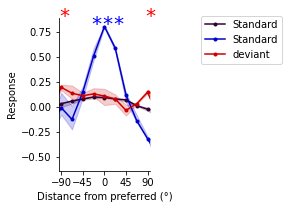

-90.0


In [71]:
import seaborn as sb
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums

incUnits = np.where((np.mean(abs(TC),1)!=0) & (np.max(TCdev,1)<4) & (TC[:,int(len(bins)/2)-1]>TC[:,0]) & (TC[:,int(len(bins)/2)+1]>TC[:,-1]))[0]
print(len(incUnits))

fig,ax = plt.subplots(1,1,figsize=(6,3))
bootstrap = np.zeros((10,len(bins)))
inc = TC[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
    
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0.2,0,0.2))

bootstrap = np.zeros((10,len(bins)))
inc = TCdev[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0.8,0,0))

bootstrap = np.zeros((10,len(bins)))
inc = TCstnd[incUnits,:]
n = int(len(inc)/10)
for k in range(10):
    ind = np.delete(np.arange(len(incUnits)),np.arange(k*n,(k+1)*n))
    bootstrap[k,:] = np.median(inc[ind,:],0)
plt.fill_between(bins,np.min(bootstrap,0),np.max(bootstrap,0),
        alpha=.2,color=(0,0,0.8))

plt.plot(bins,np.median(TC[incUnits,:],0),'.-',color=(0.2,0,0.2),label='Standard')
plt.plot(bins,np.median(TCstnd[incUnits,:],0),'.-',color=(0,0,0.8),label='Standard')
plt.plot(bins,np.median(TCdev[incUnits,:],0),'.-',color=(0.8,0,0),label='deviant')



## stats
pval = np.zeros(len(bins))
stats = np.zeros(len(bins))
pval_stnd = np.zeros(len(bins))
stats_stnd = np.zeros(len(bins))
for i in range(len(bins)):
    stat,p = ranksums(TC[incUnits,i],TCdev[incUnits,i])
    stats[i] = stat
    pval[i] = p
    stat,p = ranksums(TC[incUnits,i],TCstnd[incUnits,i])
    stats_stnd[i] = stat
    pval_stnd[i] = p
    
# deviant
rej,p = fdrcorrection(pval)
print(rej)
for i,dist in enumerate(np.where(rej)[0]):
    plt.annotate("*",color='r',size=20,xy=(bins[dist]-4,.85))

# standard
rej,p = fdrcorrection(pval_stnd)
for i,dist in enumerate(np.where(rej)[0]):
    plt.annotate("*",color='b',size=20,xy=(bins[dist]-4,.77))
    
    
ax.set_xlim(-95,95)
sb.despine()
ax.set_xlabel('Distance from preferred (°)')
ax.set_ylabel('Response')
ax.legend(bbox_to_anchor=(1.5, 1.05))
ax.set_xticks(np.arange(-90,91,45))
#ax.set_ylim(-0.4,0.85)
plt.tight_layout()
plt.savefig('NIP_Tuning_CtrlStndDev.png')
plt.show()
print(bins[np.argmax(np.median(TCdev[incUnits,:],0))])

In [898]:
pval

array([3.26227862e-01, 7.82777628e-01, 2.03123976e-01, 3.76687945e-02,
       1.38219138e-12, 8.17394572e-02, 9.87069826e-02, 2.48823525e-04,
       8.24735692e-14, 1.32843480e-06, 1.23756530e-03, 2.93295423e-01,
       1.92037623e-10, 8.54243384e-03, 8.69894164e-01, 9.21390211e-01])

### Tuning of certain units

In [704]:
TC.shape

(128, 16)

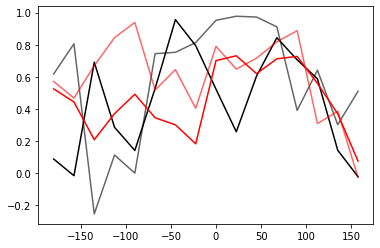

In [925]:
coef = np.mean(CoefLocal[:,3,:],0)
ind = np.argsort(coef)
plt.plot(bins,TCstnd[ind[-1],:],'k')
plt.plot(bins,TCstnd[ind[-2],:],'k',alpha=.6)
plt.plot(bins,TCdev[ind[-1],:],'r')
plt.plot(bins,TCdev[ind[-2],:],'r',alpha=.6)
#plt.plot(bins,TCstnd[ind[0],:],'b')
#plt.plot(bins,TCstnd[ind[1],:],'b')
#plt.plot(bins,np.mean(TC[incUnits,],0),'k',alpha=.4)

In [926]:
responses.shape

(2000, 128)

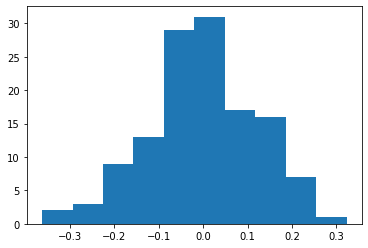

13


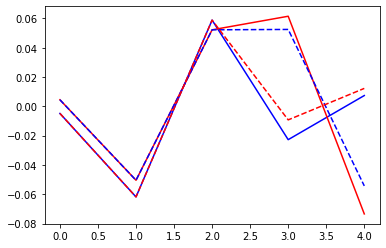

In [808]:
responses = np.concatenate((Hidden[0][:,:5,:],Hidden[2][:,:5,:]),0)
responses_loc = np.concatenate((Hidden[1][:,:5,:],Hidden[3][:,:5,:]),0)
responses_glob = np.concatenate((Hidden_2[1][:,5:10,:],Hidden_2[3][:,5:10,:]),0)
responses_locglob = np.concatenate((Hidden_2[0][:,5:10,:],Hidden_2[2][:,5:10,:]),0)

dev_effect = np.mean(responses_loc[:,3,:] - responses[:,3,:],0)
plt.hist(dev_effect)
plt.show()

plt.figure()
ind = np.argsort(dev_effect)[int(n_hidden*.9):]
print(len(ind))
plt.plot(np.median(np.mean(responses[ind,:],0),-1),'b')
plt.plot(np.median(np.mean(responses_loc[ind,:],0),-1),'r')
plt.plot(np.median(np.mean(responses_glob[ind,:],0),-1),'b--')
plt.plot(np.median(np.mean(responses_locglob[ind,:],0),-1),'r--')